Shot-level data shape: (18471, 23)
       id  minute        result     X      Y      xG          player h_a  \
0  535893       1  Missed Shots  0.816  0.527  0.052    Ross Barkley   h   
1  535895      13  Blocked Shot  0.734  0.635  0.018    Tahith Chong   h   
2  535896      14  Missed Shots  0.868  0.585  0.107    Ross Barkley   h   
3  535897      23  Missed Shots  0.932  0.458  0.052   Mads Andersen   h   
4  535903      38  Missed Shots  0.870  0.646  0.051  Elijah Adebayo   h   

   player_id    situation  ...  h_team    a_team  h_goals a_goals  \
0        592    Open Play  ...   Luton  West Ham        1       2   
1       7439    Open Play  ...   Luton  West Ham        1       2   
2        592    Open Play  ...   Luton  West Ham        1       2   
3      11715  From Corner  ...   Luton  West Ham        1       2   
4      11718    Open Play  ...   Luton  West Ham        1       2   

             date    player_assisted  lastAction goal   X   Y  
0  9/1/2023 19:00            

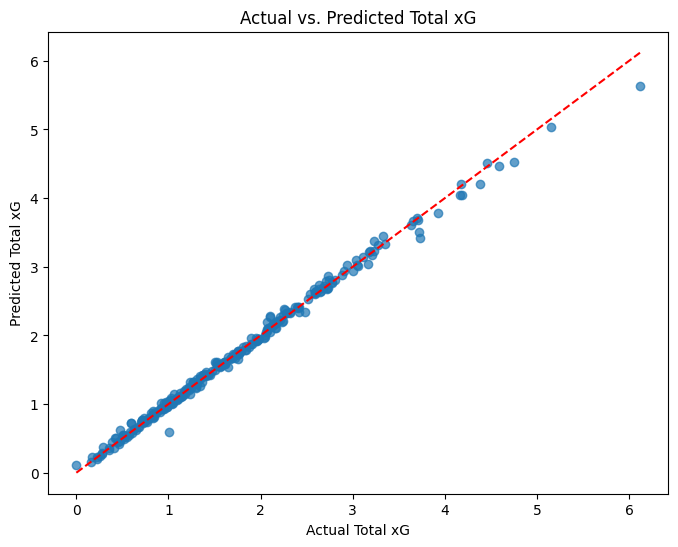

Predicted total xG for the upcoming match for the team: 1.7370747939346018
Aggregated match-level data saved to: /content/match_level_data.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ===============================
# Step 1: Load Shot-Level Data from Colab
# ===============================
# Assuming your file is uploaded to Colab's /content/ directory
file_path = "/content/EPL_2023-24_all_matches_shots.csv"
df = pd.read_csv(file_path)

print("Shot-level data shape:", df.shape)
print(df.head())

# If a 'team' column doesn't exist, try to create it from 'h_a' if available.
if 'team' not in df.columns:
    if 'h_a' in df.columns:
        df['team'] = df['h_a'].map(lambda x: 'Home' if str(x).lower() == 'h' else ('Away' if str(x).lower() == 'a' else None))
    else:
        raise ValueError("The data must contain a 'team' or 'h_a' column to identify the team.")

print("Columns after updating:", df.columns.tolist())

# ===============================
# Step 2: Ensure xG exists or simulate it
# ===============================
# Step 2: Create a 'goal' Column if Needed
if 'goal' not in df.columns:
    if 'result' in df.columns:
        # Let's check unique values in 'result' to be sure
        print("Unique values in 'result' column:", df['result'].unique())
        df['goal'] = df['result'].apply(lambda x: 1 if str(x).strip().lower() == 'goal' else 0)
        print("✅ Created 'goal' column from 'result'.")
    else:
        raise KeyError("❌ The data must contain either a 'goal' or 'result' column.")


# ===============================
# Step 3: Aggregate Shot-Level Data to Match-Level (Team-Level)
# ===============================
# We want to compute for each team-match:
# - total_xG: sum of xG (target)
# - avg_shot_xG: mean xG per shot
# - shot_count: number of shots taken
# - goals: sum of the 'goal' column (count of goals)
agg_funcs = {
    'xG': ['sum', 'mean', 'count'],
    'goal': 'sum'
}
df_agg = df.groupby(['match_id', 'team']).agg(agg_funcs)
df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]
df_agg = df_agg.reset_index()

df_agg.rename(columns={
    'xG_sum': 'total_xG',
    'xG_mean': 'avg_shot_xG',
    'xG_count': 'shot_count',
    'goal_sum': 'goals'
}, inplace=True)

# Compute conversion rate: goals divided by shot_count
df_agg['conversion_rate'] = df_agg['goals'] / df_agg['shot_count']
df_agg.fillna(0, inplace=True)

print("Aggregated match-level data shape:", df_agg.shape)
print(df_agg.head())

# ===============================
# Step 4: Build and Train a Predictive Model
# ===============================
# We will use 'shot_count', 'avg_shot_xG', and 'conversion_rate' as features.
# The target variable is 'total_xG'.
feature_cols = ['shot_count', 'avg_shot_xG', 'conversion_rate']
target_col = 'total_xG'

X = df_agg[feature_cols]
y = df_agg[target_col]

# Split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ===============================
# Step 5: Evaluate the Model
# ===============================
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot Actual vs. Predicted Total xG
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Total xG")
plt.ylabel("Predicted Total xG")
plt.title("Actual vs. Predicted Total xG")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# ===============================
# Step 6: Pre-Match Prediction Example
# ===============================
# Suppose that for an upcoming match, based on recAVent form, you estimate:
#   - shot_count: 15
#   - avg_shot_xG: 0.12
#   - conversion_rate: 0.15
upcoming_features = pd.DataFrame({
    'shot_count': [15],
    'avg_shot_xG': [0.12],
    'conversion_rate': [0.15]
})
predicted_xG = model.predict(upcoming_features)
print("Predicted total xG for the upcoming match for the team:", predicted_xG[0])

# ===============================
# Step 7: Save the Aggregated Data (Optional)
# ===============================
output_agg_path = "/content/match_level_data.csv"
df_agg.to_csv(output_agg_path, index=False)
print(f"Aggregated match-level data saved to: {output_agg_path}")


In [ ]:
import pandas as pd

# Load your uploaded CSV file
file_path = "/content/EPL_2023-24_all_matches_shots.csv"
df = pd.read_csv(file_path)

# Step 1: Basic shape and columns
print("✅ Data shape:", df.shape)
print("✅ Columns in your data:", df.columns.tolist())

# Step 2: Preview data
print("\n📊 Preview of your data:")
print(df.head())

# Step 3: Check if xG column exists and its name
# Let’s detect possible xG column names (sometimes named differently)
possible_xg_columns = [col for col in df.columns if 'xg' in col.lower()]
print("\n🔍 Detected xG columns:", possible_xg_columns)

# Step 4: Check 'result' column for goal info
if 'result' in df.columns:
    print("\n🔍 Unique values in 'result' column:", df['result'].unique())
else:
    print("\n⚠️ No 'result' column found.")

# Step 5: Check if 'goal' column exists
if 'goal' in df.columns:
    print("✅ 'goal' column exists.")
else:
    print("⚠️ No 'goal' column, we will need to create it from 'result'.")

# Step 6: Check team info
if 'team' in df.columns:
    print("\n✅ 'team' column exists.")
else:
    print("\n⚠️ No 'team' column found. Checking 'h_a' column...")
    if 'h_a' in df.columns:
        print("ℹ️ 'h_a' column exists, which we can map to home/away team info.")
    else:
        print("❌ Neither 'team' nor 'h_a' column found. You will need team identifiers.")

# Step 7: Check for match_id (important for grouping)
if 'match_id' in df.columns:
    print("✅ 'match_id' column exists.")
else:
    print("⚠️ No 'match_id' column found. We need it to aggregate shots per match.")

# Step 8: Quick summary stats of xG column
if possible_xg_columns:
    xg_column = possible_xg_columns[0]  # Assume first match
    print(f"\n📊 Summary stats for {xg_column}:")
    print(df[xg_column].describe())


✅ Data shape: (10492, 20)
✅ Columns in your data: ['id', 'minute', 'result', ' X ', ' Y ', 'xG', 'player', 'h_a', 'player_id', 'situation', 'season', 'shotType', 'match_id', 'h_team', 'a_team', 'h_goals', 'a_goals', 'date', 'player_assisted', 'lastAction']

📊 Preview of your data:
       id  minute        result     X      Y      xG          player h_a  \
0  535893       1  Missed Shots  0.816  0.527  0.052    Ross Barkley   h   
1  535895      13  Blocked Shot  0.734  0.635  0.018    Tahith Chong   h   
2  535896      14  Missed Shots  0.868  0.585  0.107    Ross Barkley   h   
3  535897      23  Missed Shots  0.932  0.458  0.052   Mads Andersen   h   
4  535903      38  Missed Shots  0.870  0.646  0.051  Elijah Adebayo   h   

   player_id    situation  season    shotType  match_id h_team    a_team  \
0        592    Open Play    2023  Right Foot     21925  Luton  West Ham   
1       7439    Open Play    2023   Left Foot     21925  Luton  West Ham   
2        592    Open Play    2023

In [ ]:
import pandas as pd

# Step 1: Load your CSV file
file_path = "/content/EPL_2023-24_all_matches_shots.csv"
df = pd.read_csv(file_path)

# Step 2: Create 'goal' column from 'result' column
# This will set goal = 1 if result == 'Goal', else 0
df['goal'] = df['result'].apply(lambda x: 1 if str(x).strip().lower() == 'goal' else 0)

# Step 3: Save the updated DataFrame back to CSV (overwrite the file or create a new one)
# Option 1: Overwrite existing file
df.to_csv("/content/EPL_2023-24_all_matches_shots.csv", index=False)

# Option 2: Save as new file
df.to_csv("/content/EPL_2023-24_all_matches_shots_with_goal.csv", index=False)

print("✅ 'goal' column added and file saved successfully!")


✅ 'goal' column added and file saved successfully!


In [ ]:
import pandas as pd

# Step 1: Load both files
agg_file = "/content/match_level_data.csv"
shot_file = "/content/EPL_2023-24_all_matches_shots.csv"

df_agg = pd.read_csv(agg_file)
df_shots = pd.read_csv(shot_file)

# Step 2: Create match-to-team mapping
# Extract only relevant columns and drop duplicates
match_team_map = df_shots[['match_id', 'h_team', 'a_team']].drop_duplicates()

# Step 3: Merge mapping into aggregated data
df_agg = df_agg.merge(match_team_map, on='match_id', how='left')

# Step 4: Create the final team name column
df_agg['team_name'] = df_agg.apply(lambda row: row['h_team'] if row['team'] == 'Home' else row['a_team'], axis=1)

# Step 5: Save the updated data
output_path = "/content/match_level_data_with_team_names.csv"
df_agg.to_csv(output_path, index=False)

print(f"✅ Updated data saved to: {output_path}")
print(df_agg.head())


✅ Updated data saved to: /content/match_level_data_with_team_names.csv
   match_id  team  total_xG  avg_shot_xG  shot_count  goals  conversion_rate  \
0     21925  Away     1.225     0.136111           9      2         0.222222   
1     21925  Home     2.204     0.137750          16      1         0.062500   
2     21926  Away     3.262     0.191882          17      2         0.117647   
3     21926  Home     1.657     0.127462          13      1         0.076923   
4     21927  Away     1.888     0.314667           6      1         0.166667   

             h_team    a_team         team_name  
0             Luton  West Ham          West Ham  
1             Luton  West Ham             Luton  
2  Sheffield United   Everton           Everton  
3  Sheffield United   Everton  Sheffield United  
4   Manchester City    Fulham            Fulham  


In [ ]:
import pandas as pd

# Load your latest aggregated data
df = pd.read_csv("/content/match_level_data_with_team_names.csv")

# Add opponent team name
df['opponent_team'] = df.apply(
    lambda row: row['a_team'] if row['team'] == 'Home' else row['h_team'],
    axis=1
)

# Save updated file
df.to_csv("/content/match_level_data_with_opponents.csv", index=False)

print("✅ Opponent team name added! File saved as: /content/match_level_data_with_opponents.csv")
print(df.head())


✅ Opponent team name added! File saved as: /content/match_level_data_with_opponents.csv
   match_id  team  total_xG  avg_shot_xG  shot_count  goals  conversion_rate  \
0     21925  Away     1.225     0.136111           9      2         0.222222   
1     21925  Home     2.204     0.137750          16      1         0.062500   
2     21926  Away     3.262     0.191882          17      2         0.117647   
3     21926  Home     1.657     0.127462          13      1         0.076923   
4     21927  Away     1.888     0.314667           6      1         0.166667   

             h_team    a_team         team_name     opponent_team  
0             Luton  West Ham          West Ham             Luton  
1             Luton  West Ham             Luton          West Ham  
2  Sheffield United   Everton           Everton  Sheffield United  
3  Sheffield United   Everton  Sheffield United           Everton  
4   Manchester City    Fulham            Fulham   Manchester City  


In [ ]:
#Cleaning the newly scraped data
import pandas as pd

# Step 1: Load your combined CSV file
file_path = "/content/EPL_2023-24_all_matches_shots.csv"  # Update if needed
df = pd.read_csv(file_path)

print(f"✅ Loaded data: {df.shape[0]} rows")
print("Columns:", df.columns.tolist())

# Step 2: Define replacement mappings
replacements = {
    'RightFoot': 'Right Foot',
    'LeftFoot': 'Left Foot',
    'Head': 'Head',
    'OpenPlay': 'Open Play',
    'FromCorner': 'From Corner',
    'DirectFreekick': 'Direct Free kick',
    'ThrowInSetPiece': 'Throw In Set Piece',
    'MissedShots': 'Missed Shots',
    'BlockedShot': 'Blocked Shot',
    'SavedShot': 'Saved Shot',
    'BallRecovery': 'Ball Recovery',
    'BallTouch': 'Ball Touch',
    'BlockedPass': 'Blocked Pass',
    'ChanceMissed': 'Chance Missed',
    'CornerAwarded': 'Corner Awarded',
    'HeadPass': 'Head Pass',
    'OffsidePass': 'Offside Pass',
    'OffsideProvoked': 'Offside Provoked',
    'LayOff': 'Lay Off',
    'ShieldBallOpp': 'Shield Ball Opp',
    'TakeOn': 'Take On',
    'Throughball': 'Through ball'
    # Add more if needed
}

# Step 3: Define columns to clean
columns_to_clean = ['shotType', 'situation', 'result', 'lastAction']

# Step 4: Apply replacements
for col in columns_to_clean:
    if col in df.columns:
        df[col] = df[col].replace(replacements)
        print(f"✅ Cleaned column: {col}")

# Step 5: Save cleaned file
cleaned_file_path = "/content/EPL_2023-24_all_matches_shots_CLEANED.csv"
df.to_csv(cleaned_file_path, index=False)
print(f"✅ Cleaned file saved to: {cleaned_file_path}")

# Step 6: Download cleaned file to your computer
from google.colab import files
files.download(cleaned_file_path)


✅ Loaded data: 18471 rows
Columns: ['id', 'minute', 'result', ' X ', ' Y ', 'xG', 'player', 'h_a', 'player_id', 'situation', 'season', 'shotType', 'match_id', 'h_team', 'a_team', 'h_goals', 'a_goals', 'date', 'player_assisted', 'lastAction', 'goal', 'X', 'Y']
✅ Cleaned column: shotType
✅ Cleaned column: situation
✅ Cleaned column: result
✅ Cleaned column: lastAction
✅ Cleaned file saved to: /content/EPL_2023-24_all_matches_shots_CLEANED.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Building predictive dataset ( rolling form )
import pandas as pd

# Step 1: Load cleaned data
file_path = "/content/EPL_2023-24_all_matches_shots_CLEANED.csv"
df = pd.read_csv(file_path)

# Step 2: Prepare basic aggregation per match & team
agg_funcs = {
    'xG': ['sum', 'mean', 'count'],
    'goal': 'sum'
}
df_agg = df.groupby(['match_id', 'h_a', 'h_team', 'a_team']).agg(agg_funcs).reset_index()
df_agg.columns = ['match_id', 'h_a', 'home_team', 'away_team', 'total_xG', 'avg_shot_xG', 'shot_count', 'goals']

# Step 3: Add team column based on h_a
df_agg['team'] = df_agg.apply(lambda row: row['home_team'] if row['h_a'] == 'h' else row['away_team'], axis=1)

# Step 4: Sort data for rolling calculations
df_agg = df_agg.sort_values(by=['team', 'match_id']).reset_index(drop=True)

# Step 5: Rolling features (last 5 matches form)
df_agg['rolling_xG'] = df_agg.groupby('team')['total_xG'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)
df_agg['rolling_shots'] = df_agg.groupby('team')['shot_count'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)
df_agg['rolling_conversion'] = df_agg.groupby('team').apply(lambda x: x['goals'].rolling(window=5, min_periods=1).sum() / x['shot_count'].rolling(window=5, min_periods=1).sum()).reset_index(level=0, drop=True)

# Step 6: Clean up final dataset
df_features = df_agg[['match_id', 'team', 'total_xG', 'shot_count', 'avg_shot_xG', 'goals', 'rolling_xG', 'rolling_shots', 'rolling_conversion', 'h_a']]

print("✅ Feature engineering complete!")
print(df_features.head())

# Step 7: Save for modeling
df_features.to_csv("/content/team_form_features.csv", index=False)
print("✅ Features saved to /content/team_form_features.csv")


✅ Feature engineering complete!
   match_id     team  total_xG  shot_count  avg_shot_xG  goals  rolling_xG  \
0     21934  Arsenal     1.911          17     0.112412      3    1.911000   
1     21941  Arsenal     0.828          13     0.063692      1    1.369500   
2     21952  Arsenal     2.342          13     0.180154      1    1.693667   
3     21959  Arsenal     4.136          15     0.275733      4    2.304250   
4     21965  Arsenal     0.390          12     0.032500      1    1.921400   

   rolling_shots  rolling_conversion h_a  
0      17.000000            0.176471   h  
1      15.000000            0.133333   a  
2      14.333333            0.116279   h  
3      14.500000            0.155172   a  
4      14.000000            0.142857   h  
✅ Features saved to /content/team_form_features.csv


<ipython-input-3-850f134d4090>:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_agg['rolling_conversion'] = df_agg.groupby('team').apply(lambda x: x['goals'].rolling(window=5, min_periods=1).sum() / x['shot_count'].rolling(window=5, min_periods=1).sum()).reset_index(level=0, drop=True)


In [2]:
import pandas as pd

# Load cleaned shot-level data
file_path = "/content/EPL_2023-24_all_matches_shots_CLEANED.csv"
df = pd.read_csv(file_path)

# Ensure date column is datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Assign team and opponent names
df['team'] = df.apply(lambda row: row['h_team'] if row['h_a'] == 'h' else row['a_team'], axis=1)
df['opponent_team'] = df.apply(lambda row: row['a_team'] if row['h_a'] == 'h' else row['h_team'], axis=1)

# Aggregate to match level
agg_funcs = {
    'xG': ['sum', 'mean', 'count'],
    'goal': 'sum'
}
df_agg = df.groupby(['team', 'match_id', 'date', 'h_a', 'opponent_team']).agg(agg_funcs).reset_index()
df_agg.columns = ['team', 'match_id', 'date', 'h_a', 'opponent_team', 'total_xG', 'avg_shot_xG', 'shot_count', 'goals']

# Sort for rolling metrics
df_agg = df_agg.sort_values(by=['team', 'date']).reset_index(drop=True)

# Add opponent match stats (true alignment)
opponent_stats = df_agg[['team', 'match_id', 'total_xG', 'shot_count', 'goals']]
opponent_stats = opponent_stats.rename(columns={
    'team': 'opponent_team',
    'total_xG': 'opponent_xG',
    'shot_count': 'opponent_shots',
    'goals': 'opponent_goals'
})
df_merged = pd.merge(df_agg, opponent_stats, on=['opponent_team', 'match_id'], how='left')

# Rolling metrics
def add_rolling(df):
    df = df.sort_values(by='date')
    g = df.groupby('team')

    df['rolling_xG'] = g['total_xG'].rolling(5, min_periods=1).mean().reset_index(level=0, drop=True)
    df['rolling_shots'] = g['shot_count'].rolling(5, min_periods=1).mean().reset_index(level=0, drop=True)
    df['rolling_avg_shot_xG'] = g['avg_shot_xG'].rolling(5, min_periods=1).mean().reset_index(level=0, drop=True)
    df['rolling_conversion'] = (g['goals'].rolling(5, min_periods=1).sum() / g['shot_count'].rolling(5, min_periods=1).sum()).reset_index(level=0, drop=True)

    df['rolling_shots_conceded'] = g['opponent_shots'].rolling(5, min_periods=1).sum().reset_index(level=0, drop=True)
    df['rolling_goals_conceded'] = g['opponent_goals'].rolling(5, min_periods=1).sum().reset_index(level=0, drop=True)
    df['rolling_opponent_conversion_rate'] = (df['rolling_goals_conceded'] / df['rolling_shots_conceded']).fillna(0)

    return df

# Apply to home and away
home_df = add_rolling(df_merged[df_merged['h_a'] == 'h'])
away_df = add_rolling(df_merged[df_merged['h_a'] == 'a'])

# Export summaries (latest form)
home_summary = home_df.sort_values(by='date').groupby('team').last().reset_index()
away_summary = away_df.sort_values(by='date').groupby('team').last().reset_index()

# Save to CSV
home_summary.to_csv("/content/Home_Form_Summary_UPDATED.csv", index=False)
away_summary.to_csv("/content/Away_Form_Summary_UPDATED.csv", index=False)

print("✅ Rolling attack and defense summaries saved!")

# Optional: download
from google.colab import files
files.download("/content/Home_Form_Summary_UPDATED.csv")
files.download("/content/Away_Form_Summary_UPDATED.csv")


✅ Rolling attack and defense summaries saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Creating match training data for the model
import pandas as pd

# Step 1: Load your home and away summary files
home_form = pd.read_csv("/content/Home_Form_Summary (1).csv")
away_form = pd.read_csv("/content/Away_Form_Summary (1).csv")

# Step 2: Load your shot-level cleaned data to get match IDs and team info
matches = pd.read_csv("/content/EPL_2023-24_all_matches_shots_CLEANED.csv")

# Step 3: Prepare match-level data
# We'll group by match_id to get home and away teams and goals
match_summary = matches.groupby('match_id').agg({
    'h_team': 'first',
    'a_team': 'first',
    'h_goals': 'first',
    'a_goals': 'first',
    'date': 'first'
}).reset_index()

# Step 4: Merge home team form data
merged = match_summary.merge(home_form, left_on='h_team', right_on='team', suffixes=('', '_home'))
# Drop duplicate 'team' column from merge
merged.drop(columns=['team'], inplace=True)

# Step 5: Merge away team form data
merged = merged.merge(away_form, left_on='a_team', right_on='team', suffixes=('', '_away'))
merged.drop(columns=['team'], inplace=True)

# Step 6: Rename columns to clarify home/away features
merged.columns = [col if col in ['match_id', 'h_team', 'a_team', 'h_goals', 'a_goals', 'date']
                  else f"{col}_away" if col.endswith('_away')
                  else f"{col}_home" for col in merged.columns]

# Step 7: Optional - calculate target variables (total goals etc.)
merged['total_goals'] = merged['h_goals'] + merged['a_goals']
merged['goal_difference'] = merged['h_goals'] - merged['a_goals']

# Step 8: Check the final dataframe
print("✅ Final merged dataset shape:", merged.shape)
print(merged.head())

# Step 9: Save to CSV
final_path = "/content/Match_Training_Dataset.csv"
merged.to_csv(final_path, index=False)
print(f"🚀 Final training dataset saved to: {final_path}")

# Optional: Download the file to your local machine
from google.colab import files
files.download(final_path)


✅ Final merged dataset shape: (685, 42)
   match_id            h_team       a_team  h_goals  a_goals            date  \
0     21925             Luton     West Ham        1        2  9/1/2023 19:00   
1     21926  Sheffield United      Everton        2        2  9/2/2023 11:30   
2     21927   Manchester City       Fulham        5        1  9/2/2023 14:00   
3     21928         Brentford  Bournemouth        2        2  9/2/2023 14:00   
4     21929           Burnley    Tottenham        2        5  9/2/2023 14:00   

   match_id_home_home   date_home_home h_a_home opponent_team_home  ...  \
0               22272  5/19/2024 15:00        h             Fulham  ...   
1               22274  5/19/2024 15:00        h          Tottenham  ...   
2               26898   4/2/2025 19:45        h          Leicester  ...   
3               26903   4/6/2025 13:00        h            Chelsea  ...   
4               22268  5/19/2024 15:00        h  Nottingham Forest  ...   

   rolling_shots_away_away  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Data loaded. Shape: (685, 42)
🏠 Home Goals Model MAE: 1.083
🏠 Home Goals Model RMSE: 1.375
🛫 Away Goals Model MAE: 1.011
🛫 Away Goals Model RMSE: 1.324


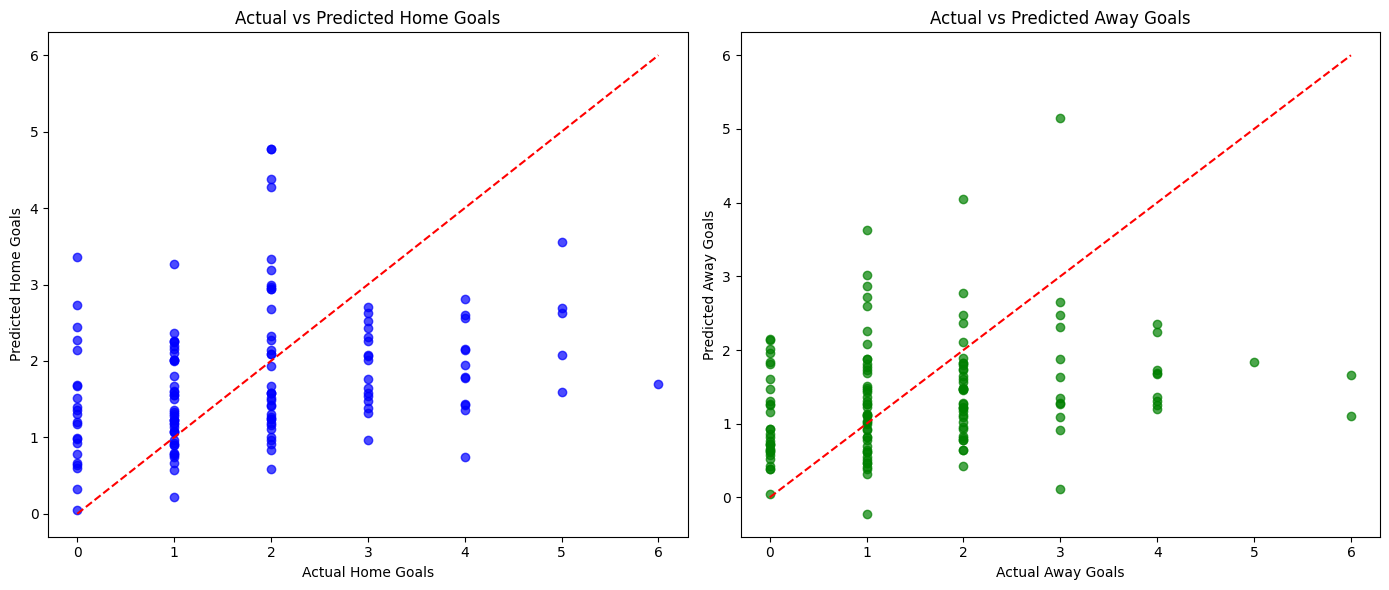

✅ Model training and evaluation completed.


In [ ]:
#Training model to get h_goals and a_goals
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Load the cleaned training data
file_path = "/content/Match_Training_Dataset.csv"
df = pd.read_csv(file_path)

print("✅ Data loaded. Shape:", df.shape)

# Step 2: Define features and target
feature_cols = [
    'rolling_xG_home', 'rolling_shots_home', 'rolling_avg_shot_xG_home', 'rolling_conversion_home',
    'rolling_shots_conceded_home', 'rolling_goals_conceded_home', 'rolling_opponent_conversion_rate_home',
    'rolling_xG_away', 'rolling_shots_away', 'rolling_avg_shot_xG_away', 'rolling_conversion_away',
    'rolling_shots_conceded_away', 'rolling_goals_conceded_away', 'rolling_opponent_conversion_rate_away'
]

target_home = 'h_goals'
target_away = 'a_goals'

# Step 3: Prepare data
X = df[feature_cols].fillna(0)  # Fill NaNs with zeros
y_home = df[target_home]
y_away = df[target_away]

# Step 4: Train/test split
X_train, X_test, y_train_home, y_test_home = train_test_split(X, y_home, test_size=0.2, random_state=42)
_, _, y_train_away, y_test_away = train_test_split(X, y_away, test_size=0.2, random_state=42)

# Step 5: Initialize models
model_home = GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=42)
model_away = GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=42)

# Step 6: Train models
model_home.fit(X_train, y_train_home)
model_away.fit(X_train, y_train_away)

# Step 7: Predictions
y_pred_home = model_home.predict(X_test)
y_pred_away = model_away.predict(X_test)

# Step 8: Evaluation
def evaluate_model(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} MAE: {mae:.3f}")
    print(f"{label} RMSE: {rmse:.3f}")

evaluate_model(y_test_home, y_pred_home, "🏠 Home Goals Model")
evaluate_model(y_test_away, y_pred_away, "🛫 Away Goals Model")

# Step 9: Visualization
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_home, y_pred_home, alpha=0.7, color='blue')
plt.plot([y_test_home.min(), y_test_home.max()], [y_test_home.min(), y_test_home.max()], 'r--')
plt.title('Actual vs Predicted Home Goals')
plt.xlabel('Actual Home Goals')
plt.ylabel('Predicted Home Goals')

plt.subplot(1, 2, 2)
plt.scatter(y_test_away, y_pred_away, alpha=0.7, color='green')
plt.plot([y_test_away.min(), y_test_away.max()], [y_test_away.min(), y_test_away.max()], 'r--')
plt.title('Actual vs Predicted Away Goals')
plt.xlabel('Actual Away Goals')
plt.ylabel('Predicted Away Goals')

plt.tight_layout()
plt.show()

print("✅ Model training and evaluation completed.")
